# Alberta Wildfire Area Statistics Compilation
Author: Jason R. Wang

Last modified: 2019-10-29 (or the latest date shown on my GitHub repo)

See on GitHub: [jasonrwang/AB-Wildfire](https://github.com/jasonrwang/AB-Wildfire)

## Preamble

Wildfire season has hit Alberta once again, and my friends and family back home are posting feverously on social media about the orange haze that has hit Alberta. Of course, there's similarly bickering about how much of this is 'normal'. We know that wildfires are intensified by the climate emergency, but there are undoubtedly many more causes.

The purpose of this little notebook is just to answer a question that's been on my mind: _how does this wildfire season actually compare to previous years?_ Surprisingly, this wasn't very easy to find online, so I decided to do some work myself.

Of course this analysis is limited by the quality of data available. I've done my best to double check and, where I could, validate these numbers by cross-referencing them across multiple government-published data sources.

This is by no means a comprehensive study (it's just to answer one small question transparently). There's a lot more work done 

Lastly, I want to thank all the brave lookout staff, firefighters, civil servants, and countless more people on the frontlines fighting the fires. It's a dangerous and incredibly tiring job to deal with such crises. Similarly, my heart goes out to all those displaced by the fires.

### To Do:
- Look at other factors for fires, like aridity and duration of actual fire season

### For more reading:

#### Explained
- [Carman, Tara (2017, July 29). Area of B.C. burned by wildfires at a 56-year high. CBC News.](https://www.cbc.ca/news/canada/british-columbia/area-of-b-c-burned-by-wildfires-at-a-56-year-high-1.4226227)
- Tara Carman's [GitHub Repo](https://github.com/taracarman/BC_Wildfires/blob/master/BC%20Wildfires.ipynb) for the above story
- [Nadkarni, Kabir (2018, September 01). Opinion: UCP's climate denial unacceptable in face of worsening wildfire trends. The Gateway.](https://www.thegatewayonline.ca/2018/09/ucp-climate-denial-unacceptable-wildfire-trends/)
- [McGillivray, Glenn (2019, May 29). Opinion: Climate change is a big factor in Alberta’s wildfires – but not in the way you might think. The Globe and Mail.](https://www.theglobeandmail.com/opinion/article-climate-change-is-a-big-factor-in-albertas-wildfires-but-not-in-the/)
- [Pierre-Louis, Kendra & Popovich, Nadja (2018, November 27). Climate Change Is Fueling Wildfires Nationwide, New Report Warns. The New York Times.](https://www.nytimes.com/interactive/2018/11/27/climate/wildfire-global-warming.html)
- [Thomson, Graham (2019, May 29). Opinion: Kenney not a climate change denier but a climate change dodger. iPolitics](https://ipolitics.ca/2019/05/29/kenney-not-a-climate-change-denier-but-a-climate-change-dodger/)

#### Academic
- [Flannigan, Mike (n.d.). Fire and Climate Change. University of Alberta.](https://sites.ualberta.ca/~flanniga/climatechange.html)
- [cffdrs: an R package for the Canadian Forest Fire Danger Rating System. Canada Wildfire.](https://www.canadawildfire.org/cffdrs-r-package)
- (Paywalled) [Robinne, F.-N., Parisien, M.-A., & Flannigan, M. (2016). Anthropogenic influence on wildfire activity in Alberta, Canada. International Journal of Wildland Fire, 25(11), 1131.](https://doi.org/10.1071/WF16058)

## Data Cleaning and Prep

The most comprehensive database I could find for Alberta's wildfire data is from the AB Ministry of Agriculture and Forestry's [Historical Wildfire Database](https://wildfire.alberta.ca/resources/historical-data/historical-wildfire-database.aspx). Data between 1918 and 1979 are also available in scanned form from Natural Resource Canada [here](https://cfs.nrcan.gc.ca/publications?id=8998). Unfortunately, this set needs to be added in manually, so I created a CSV to host them.

There is also aggregated data at the [Canadian National Fire Database](http://cwfis.cfs.nrcan.gc.ca/ha/nfdb) and the [National Forestry Database](http://nfdp.ccfm.org/en/index.php). Unfortunately, they only have records from 1990 onwards.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

Let's first import all four data files and inspect them for what information they actually carry. The accompanying PDF 'data_dictionary' files explain what is in each column.

In [2]:
# Import data
df1 = pd.read_csv('data/AB/fires_1961to1982.csv')
df2 = pd.read_csv('data/AB/fires_1983to1995.csv', low_memory = False) # Columns (17,76,77) have mixed types
df3 = pd.read_csv('data/AB/fires_1996to2005.csv')
# The most recent file has a 0x92 byte, which is a special apostrophe made by Windows
df4 = pd.read_csv('data/AB/fires_2006to2017.csv', encoding='cp1252')
df5 = pd.read_csv('data/AB/stocks1981_AB.csv')

In [3]:
# Check column names of the datasets
df3.columns

Index(['fire_number', 'fire_name', 'fire_year', 'calendar_year',
       'assessment_datetime', 'assessment_hectares', 'current_size',
       'size_class', 'fire_location_latitude', 'fire_location_longitude',
       'fire_origin', 'general_cause_desc', 'industry_identifier_desc',
       'responsible_group_desc', 'activity_class', 'true_cause',
       'permit_detail_desc', 'fire_start_date', 'det_agent_type', 'det_agent',
       'discovered_date', 'reported_date', 'start_for_fire_date',
       'fire_fighting_start_date', 'fire_fighting_start_size',
       'initial_action_by', 'fire_type', 'fire_position_on_slope',
       'weather_conditions_over_fire', 'fuel_type', 'other_fuel_type',
       'bh_fs_date', 'bh_hectares', 'uc_fs_date', 'uc_hectares', 'to_fs_date',
       'to_hectares', 'ex_fs_date', 'ex_hectares'],
      dtype='object')

Every one of these files has a different structure, so I'm going to manually find the ones I want. Right now, I care the most about:
- Year
- Total area burned by the fire (not every reading is the total area burned)

In [4]:
# Make a master df for everything and join others to this
df = pd.DataFrame(columns = ['Year', 'Area'])

In [5]:
# 1961-1982
df1_sub = (df1.groupby(by = ['FIRENUMBER', 'YEAR'], sort = False)['TOTAL']
           .nlargest(n=1)
           .reset_index()
           .loc[:,['YEAR', 'TOTAL']]
           .rename(columns = {'YEAR': 'Year', 'TOTAL': 'Area'})
          )

# Data only recorded last two digits of year
df1_sub.loc[:,'Year'] = df1_sub['Year'].apply(lambda x: x+1900) 

# Total burned area is recorded in acres. Since metric is better, let's convert that to hectares
df1_sub.loc[:,'Area'] = df1_sub['Area'].apply(lambda x: x * 0.404686)

df = df.append(df1_sub, ignore_index=True, sort = False)

In [6]:
# 1983-1995
df2_sub = (df2.groupby(by = ['firenumber', 'fire_year'], sort = False)['grandarea']
           .nlargest(n=1)
           .reset_index()
           .loc[:,['fire_year', 'grandarea']]
           .rename(columns = {'fire_year': 'Year', 'grandarea': 'Area'})
          )

# Documentation says col `fire_year` is only last two digits, but it's identical to `calendar_year`
# Area is listed as already in hectares

df = df.append(df2_sub, ignore_index=True)

In [7]:
# 1996-2005 and 2006-2017
# The documentation for this period doesn't match the actual column names, but the one for 2006 to 2017 does
# These two periods have the same column headings, so let's save some time and merge them early
df3 = df3.append(df4)

# Use fire_year because some of these fires continued to burn even into the winter of the following year
# df3[df3.loc[:,['fire_year']].values != df3.loc[:,['calendar_year']].values]

# Current size is implicitly in hectares (matches other columns explicitly listed as hectares)

df3_sub = (df3.groupby(by = ['fire_number', 'fire_year'], sort = False)['current_size']
           .nlargest(n=1)
           .reset_index()
           .loc[:,['fire_year', 'current_size']]
           .rename(columns = {'fire_year': 'Year', 'current_size': 'Area'})
          )

df = df.append(df3_sub, ignore_index=True)

[@\_Magma__](https://twitter.com/_Magma__/status/1134975621417844736?s=20) found a scanned book on the NRCan site with data from 1918, which I digitized in `df5` by hand. This dataset goes until 1979, so it overlaps with `df1` between 1961 and 1979. Let's take a look at how the two compare.

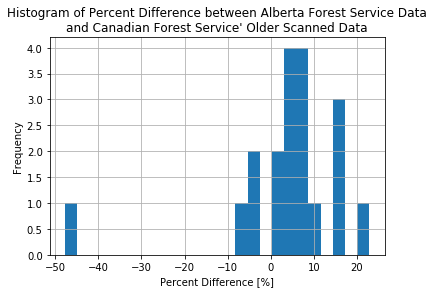

In [8]:
# Merge the two datasets together
df5_sub = df5.query('Year >= 1961 & Year <= 1979')\
    .merge(
        df.query('Year >= 1961 & Year <= 1979').groupby('Year').sum(), # df1 stored each fire separately
        on='Year'
    )

df5_sub['Difference'] = (df5_sub['Area'] - df5_sub['Total'])/df5_sub['Area'] * 100 # Find % difference relative to df
df5_sub['Difference'].hist(bins=25)
plt.title('Histogram of Percent Difference between Alberta Forest Service Data\nand Canadian Forest Service\' Older Scanned Data')
plt.ylabel('Frequency')
plt.xlabel('Percent Difference [%]')
plt.show()

<BarContainer object of 19 artists>

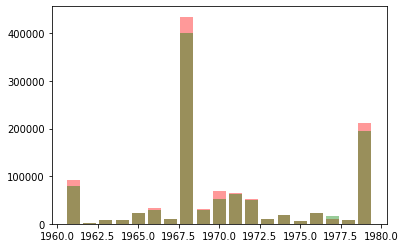

In [9]:
plt.bar(df5_sub['Year'], df5_sub['Area'], color='red', alpha = 0.4, label = 'AFS')
plt.bar(df5_sub['Year'], df5_sub['Total'], color='g', alpha = 0.4, label = 'CFS')

Interestingly, the AFS data generally overestimates CFS's except in one year where it was only around half of CFS's set! I realize I must make a choice and, to avoid data manipulation and with full admission this approach might seem alarmist, I will take the most conservative dataset. The 50% difference year was also a low fire year in the grand scheme of things. That is to say, I will only append the portion between 1918 and 1960 from the scanned dataset.

In [10]:
df5.columns = ['Year','Area'] # Rename columns
df = df.append(df5.query('Year < 1961'))

In [11]:
# Manually add 2018 data from the National Forestry Database
df = df.append(pd.DataFrame.from_dict({'Year': [2018], 'Area': [59809]}))

The 2019 data is only available on the Government of Alberta [Wildfire site](https://wildfire.alberta.ca/wildfire-status/default.aspx) right now. This information can be retrieved manually, or through some web scraping. Here's where I got it from:

![2019 Data Scrape Location](img/2019-Data-Scrape.png)

In [12]:
import requests
from bs4 import BeautifulSoup

# Inspect elements on the table 
page_name = 'https://wildfire.alberta.ca/reports/sitrep.html'
page = requests.get(page_name)

soup = BeautifulSoup(page.text, 'html.parser')
area2019 = float(
    soup
    .find_all(bgcolor='#CCCCCC')[-1] # Take last #CCCCCC shaded table cell, which is 
    .find_all('font')[0].contents[0]
    .replace(',','')
    )

In [13]:
# 2019 data as of 2019-05-31 available on https://wildfire.alberta.ca/wildfire-status/default.aspx
df = df.append(pd.DataFrame.from_dict({'Year': [2019], 'Area': [area2019]}))

In [14]:
# Save all the data as an aggregated bunch for easier processing later, or elsewhere!
df.to_csv('data/ABWildfires_1918-2019.csv', index=False)

## Data Viz and Verification

I can really only validate this data against other datasets, since I do not have access to a plane, satellite, or time machine (ranked in order of difficulty, of course). Therefore, this section is mostly to _verify_ my process, making sure that I didn't mess up any conversions or anything. Unfortunately, there's only one conversion that I needed to do, which was for acres –> hectares in the 1961 to 1982 dataset.

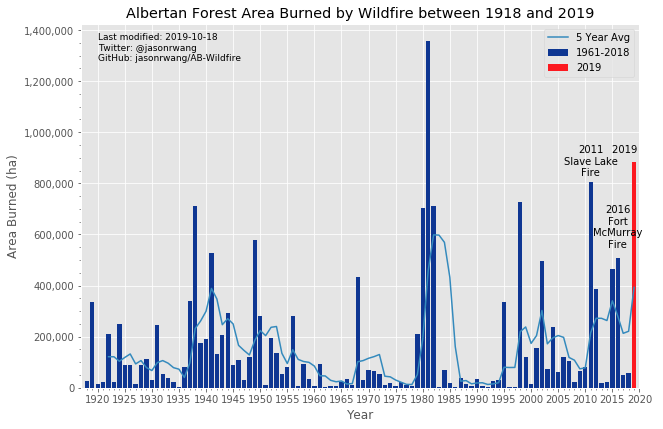

In [15]:
# Aggregate data all into years
df = df.groupby(by = 'Year').sum().reset_index()

df['avg_5yr'] = df['Area'].rolling(window=5).mean()

plt.style.use('ggplot')
fig = plt.figure(figsize=(10,6.7))
ax = fig.add_subplot(111)

plt.plot(df['avg_5yr'])
plt.bar(
    df['Year'].values, df['Area'].values,
    color='#0e3692', label='1961-2018'
)
plt.bar(
    df['Year'].tail(1).values, df['Area'].tail(1).values,
    color = '#fc1920', label='2019'
)
plt.plot(df['Year'].values, df['avg_5yr'], label='5 Year Avg')

ax.set(xlabel = 'Year',
       ylabel='Area Burned (ha)',
       title = 'Albertan Forest Area Burned by Wildfire between 1918 and 2019')
ax.legend(loc = 'upper right')

ax.set_xticks(range(1915, 2021, 5))
plt.minorticks_on()
ax.set_xlim([1917, 2020])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

credit = 'Last modified: 2019-10-18\nTwitter: @jasonrwang\nGitHub: jasonrwang/AB-Wildfire'
plt.text(1920, 1280000, credit, fontsize=9, horizontalalignment='left')
plt.text(2011, 830000, '2011\nSlave Lake\nFire', fontsize=10, horizontalalignment='center')
plt.text(2016, 550000, '2016\nFort\nMcMurray\nFire', fontsize=10, horizontalalignment='center')
plt.text(2019, 920000, '2019      ', fontsize=10, horizontalalignment='center')

# Save the the figure for other uses
plt.savefig('img/ABWildfires_1918-2019.png')
plt.show()

Compare this to [National Forest Database's compiled data for Alberta](http://nfdp.ccfm.org/en/data/fires.php). At least for the 1990-2017 time period, we have similar numbers. Recall that I took 2018 from them.
![NFD 1990-2018 Alberta Wildfire Data](img/NFD_Alberta_1990-2018.png)

The spike between 1980-1982 also seems strange. Though I don't have other data to compare against, I do have three pieces of useful comparison:

1. [National Forest Database's compiled data for Canada between 1980 and 2017](http://cwfis.cfs.nrcan.gc.ca/ha/nfdb?type=poly&year=2016). The total hectares burned in 1981 is ~6.5 million, so the ~1.4 million ha our data from the Government of Alberta seems completely reasonable.
![NFD/NFDB 1980-2017 Stats](img/NFD_NFDB_comparison_stats_chart.png)
2. [National Forest Database's mapped 1981 fire range](http://nfdp.ccfm.org/en/data/fires.php) (from Alberta's submitted map files) is visually much bigger than the same data from 2016 (see two figures below). A full set of these files is available from the Government of Alberta [here](https://wildfire.alberta.ca/resources/historical-data/spatial-wildfire-data.aspx) – including since 1931 – but I don't have the tools to analyze this right now.
![1981 Canadian Wildfire Map](img/ag_firepolys_1981.png)
3. National Forest Database's mapped 2017 fire range:
![2016 Canadian Wildfire Map](img/ag_firepolys_2016.png)

Overall then, I'm satisfied with the data I've compiled.